<a href="https://colab.research.google.com/github/katiefaull/ML/blob/master/Handwriting_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and Testing with Images from Moravian Lives Website

Importing necessary libraries

In [0]:
import cv2
import os
import os.path
from os import path
import tempfile
from sklearn.datasets import load_sample_images
from sklearn.feature_extraction import image
from skimage import data
from skimage import io
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy import stats
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pandas
import time
from sklearn.utils import shuffle
import re
import urllib

This is the deep learning model.

In [0]:
def create_model(learn_rate = 0.0005, patch_row = 100, patch_col = 200):
  model = Sequential()
  model.add(ZeroPadding2D((1, 1), input_shape=(patch_row, patch_col, 1)))
  model.add(Convolution2D(filters= 32, kernel_size =(3,3), strides= (1,1), padding='same', name='conv1', activation='relu')) #96
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

  model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2', activation='relu'))  #256
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

  model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3', activation='relu'))  #256
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


  model.add(Flatten())
  model.add(Dropout(0.5))
  
  model.add(Dense(128, name='dense3', activation='relu'))  #1024
  model.add(Dropout(0.3))
  
  model.add(Dense(64, name='dense4', activation='relu'))  #1024
  model.add(Dropout(0.3))

  model.add(Dense(NUM_AUTHORS,name='output', activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learn_rate), metrics=['accuracy'])
  print(model.summary())
  return model

This function takes a filepath with a grayscaled image and extracts a maximun of 15 patches. There can be less than 15 patches if the image fails to produce patches that pass the filter.

In [0]:
def image_patches(image_path):
  try:
    img = io.imread(image_path)
    grayscaled = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    rescale_factors = [.8,.9,1.0,1.1,1.2]
    rescaled_images = []
    for factor in rescale_factors:
      rescaled_images.append(cv2.resize(grayscaled,(0,0),fx=factor,fy=factor,interpolation = cv2.INTER_LINEAR))

    patch_list = []
    patch_nums = []
    patch_num = 0

    for i in range(NUM_PATCHES):
      is_valid_patch = False
      bad_count = 0
      while not is_valid_patch:
        rand = random.randint(0,len(rescale_factors)-1)
        patch = image.extract_patches_2d(rescaled_images[rand],patch_size=(patch_row,patch_col),max_patches=1,random_state=np.random.RandomState())[0]
        if patch.std(axis=0).std() < 5 or patch.std(axis=1).std() < 5 or patch.std(axis=0).mean() < 15 or patch.std(axis=1).mean() < 15 or patch.mean(axis=(0,1)) > 200:
          bad_count += 1
          if bad_count >= MAX_RETRY:
            plt.imshow(patch,cmap=plt.cm.gray)
            plt.show()
            print("Tried 200 Times on {}".format(image_path))
            break
        else:
          patch_list.append(patch)
          patch_nums.append(patch_num)
          is_valid_patch = True
          patch_num+=1
    print("Number of testpatches for {}: {}".format(image_path,len(patch_list)))
    return patch_list, patch_nums
  except:
    print("Error with:",image_path)
    return [],[]
    pass


Just a regex that finds all the url and the names (of the memoirs) and creates a dictionary. If multiple memoir have the same name, it combines them. 

In [0]:
def extract_url_links(url):
  all_links = {}
  url_textfile = urllib.request.urlopen(url)
  for line in url_textfile:
    name = re.findall('(([A-Z][a-z]*),\s([A-Z][a-z]*)(\s[A-Z][a-z]*)?)|(Unknown)', line.decode())
    url = re.findall('(http://[\w./|_-]*)', line.decode())
    if len(name) != 0 and not name[0][0] in all_links:
      if name[0][4] == "Unknown":
        url_links = []
        all_links[name[0][4]] = url_links
      else:
        url_links = []
        all_links[name[0][0]] = url_links
    if len(url) != 0:
      url_links.extend(url)
  return all_links

This takes a list of image urls and grayscale and rescales them and creates NUM_TRAIN_PATCHES_PER_WRITER patches for each author.

In [0]:
def author_patches(img_list):
  rescale_factors = [.8,.9,1.0,1.1,1.2]
  rescaled_images = []
  img_ids = []
  for img_url in img_list:
    img = io.imread(img_url)
    grayscaled = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    for factor in rescale_factors:
      rescaled_images.append(cv2.resize(grayscaled,(0,0),fx=factor,fy=factor,interpolation = cv2.INTER_LINEAR))
      img_ids.append(img_url)
      
  patch_list = []
  patch_nums = []
  patch_num = 0
  while len(patch_list) < NUM_TRAIN_PATCHES_PER_WRITER:
    is_valid_patch = False
    bad_count = 0
    while not is_valid_patch:
      rand = random.randint(0,len(rescale_factors)-1)
      patch = image.extract_patches_2d(rescaled_images[rand],patch_size=(patch_row,patch_col),max_patches=1,random_state=np.random.RandomState())[0]
      if patch.std(axis=0).std() < 5 or patch.std(axis=1).std() < 5 or patch.std(axis=0).mean() < 15 or patch.std(axis=1).mean() < 15 or patch.mean(axis=(0,1)) > 200:
        bad_count += 1
        if bad_count >= MAX_RETRY:
          print("Tried 200 Times on {}".format(img_ids[rand]))
          print("Stdev Stdev0: {}, Stdev Stdev1: {}, Stdev0 Mean: {}, Stdev1 Mean: {}, Mean01: {}".format(patch.std(axis=0).std(),patch.std(axis=1).std(),patch.std(axis=0).mean(),patch.std(axis=1).mean(),patch.mean(axis=(0,1))))
          plt.imshow(patch,cmap=plt.cm.gray)
          plt.show()
          break
      else:
        patch_list.append(patch)
        patch_nums.append(patch_num)
        is_valid_patch = True
        patch_num+=1
  return patch_list, patch_nums



Splits the urls to be used for training and testing, creates training and testing sets and normalizes them to be used in the model.

In [0]:
def create_and_prep_patches(authors_url_dict):
  authors_list = []
  train_patches_list = []
  test_patches_list = []
  train_tags_list = []
  test_tags_list = []
  test_img_ids = []
  tag_num = -1
  for i in authors_url_dict:
    if len(authors_url_dict[i]) >= 10:
      authors_list.append(i)
      tag_num+=1
      random.shuffle(authors_url_dict[i])
      test_size = round(len(authors_url_dict[i])*TEST_PERCENT)

      print("Creating testset for {}".format(i))
      for j in authors_url_dict[i][:test_size]:
        patches,patch_num = image_patches(j)
        test_patches_list.extend(patches)
        test_tags_list.extend([tag_num]*len(patches))
        test_img_ids.extend([j]*len(patches)) 
        
      print("Creating trainset for {}".format(i))
      patches,_ = author_patches(authors_url_dict[i][test_size:])
      train_patches_list.extend(patches)
      train_tags_list.extend([tag_num]*len(patches))
      print("Number of training patches from {}: {}".format(i,len(patches)))
  print("Finished Creating Patches")

  train_patches_list = np.array(train_patches_list)
  test_patches_list = np.array(test_patches_list)
  train_tags_list = np.array(train_tags_list)
  test_tags_list = np.array(test_tags_list)

  train_patches_list = train_patches_list.reshape(train_patches_list.shape[0],patch_row,patch_col,1)
  train_patches_list = train_patches_list.astype('float32')
  train_patches_list /= 255.0 

  test_patches_list = test_patches_list.reshape(test_patches_list.shape[0],patch_row,patch_col,1)
  test_patches_list = test_patches_list.astype('float32')
  test_patches_list /= 255.0 

  train_tags_list = to_categorical(train_tags_list)
  test_tags_list = to_categorical(test_tags_list)

  train_patches_list,train_tags_list = shuffle(train_patches_list,train_tags_list)
  
  return (authors_list,train_patches_list,test_patches_list,train_tags_list,test_tags_list,test_img_ids)


Calls the model and stores prediction into a pandas dataframe.

In [0]:
def fit_and_predict(train_patches_list, train_tags_list, test_patches_list, test_tags_list, authors_list, test_img_ids ):
  model = create_model()
  model.fit(train_patches_list, train_tags_list, epochs=NUM_EPOCHS,batch_size=32,verbose=1)
  prediction = model.predict(x=test_patches_list,verbose=1)
  df = pandas.DataFrame.from_records(prediction,columns=authors_list)
  actual_nums = np.argmax(test_tags_list,axis=1)
  df["Actual Authors"] = np.array(authors_list)[actual_nums]
  df["Image ID"] = test_img_ids
  return df

It plots and shows the results for each image as well as the total accuracy score.

In [0]:
def plot_results(authors_list,prediction_data):
  #sel = df[authors_list].apply(max,axis=1) > 0.7 
  #grouped_df = df.loc[sel].groupby(by=["Actual Authors","Image ID"])
  grouped_df = prediction_data.groupby(by=["Actual Authors","Image ID"])
  correct = 0
  correct_list = []
  incorrect_list = []
  for index, row in grouped_df[authors_list].mean().iterrows():
    dist = grouped_df[authors_list].mean().loc[index]
    predicted_author = row.idxmax(1)
    actual_author = index[0]
    color = "green"
    if predicted_author == actual_author:
      correct += 1
      print(index[1])
    else:
      color = "red"
      print(index[1])
    dist.plot.bar(color=color)
    plt.text(0,.9,"Predicted: {}\n Actual: {}".format(predicted_author,actual_author),bbox=dict(facecolor=color, alpha=0.5))
    plt.title("{}".format(index[1]))
    plt.ylim([0,1])
    plt.xlabel("Authors")
    plt.ylabel("Prediction Percentage")
    plt.show()
  acc = correct/len(grouped_df[authors_list].mean())
  print('Accuracy: {acc:.2%} '.format(acc=acc))

  _,_,bars = plt.hist(["Correct","Incorrect"],weights=[acc,1-acc],align='mid')
  plt.ylim([0,1])
  plt.title("Correct vs Incorrect Predictions")
  bars[0].set_facecolor('g')
  bars[-1].set_facecolor('r')
  plt.show()
  return acc

Takes the results, the accuracy of the images and the table and stores it into a csv file.

In [0]:
def results_to_csv(df,acc):
  
  from google.colab import auth,drive
  auth.authenticate_user()

  import gspread
  from oauth2client.client import GoogleCredentials
  import gspread_dataframe

  os.environ['TZ'] = 'US/Eastern'
  time.tzset()


  gc = gspread.authorize(GoogleCredentials.get_application_default())

  
  #Preparing to store results in a csv file
  param_data = [["Number of training patches per writer",NUM_TRAIN_PATCHES_PER_WRITER],
                ["Row Size",patch_row],["Column Size",patch_col],["Test Percentage",TEST_PERCENT],["Num Epochs",NUM_EPOCHS]]

  train_info = pandas.DataFrame(param_data, columns=['Parameter','Number'])

  t = time.localtime(time.time())
  name = "results_{}/{}/{}-{}:{}_{}_{}".format(t[0],t[1],t[2],t[3],t[4],str(NUM_PATCHES),str(NUM_EPOCHS))
  sh = gc.create(name)
  worksheet = gc.open(name).sheet1

  
  gspread_dataframe.set_with_dataframe(worksheet,train_info)
  gspread_dataframe.set_with_dataframe(worksheet,df.groupby(by=["Actual Authors","Image ID"],as_index=False).mean().round(4),row=train_info.shape[0]+2,col=1)
  gspread_dataframe.set_with_dataframe(worksheet,pandas.DataFrame([acc],columns=["Accuracy"]),row=train_info.shape[0]+df.groupby(by=["Actual Authors","Image ID"]).mean().round(4).shape[0]+4,col=1)

We need to build a training dataset that has equal number of patches per transcriber. The problem is that we don't have the same number of images supplied per transcriber. Let's take a compeltely random approach to building a solid training dataset per transcriber:

NUM_TRAIN_PATCHES_PER_WRITER = 300
This is the number of patches desired by each writer

For each writer:  
    1) Select an image at random
    2) generate a random patch
    3) Add to collection of patches for that writer

Edits:
For each writer:
    1. Load, grayscale and rescale every image and add onto a list
    2. Randomly select from the list and create 1 random patches
    3. If the patch passes, add to the collection of patches for that writer and loop until there are **NUM_TRAIN_PATCHES_PER_WRITER** patches


By the end of this algorithm, you should have an equal number of patches for each writer
    


This combines the codes and is used to run the program. 
Variables are listed there and can be changed. The 'url' can also be changed.
If you do not want the results to be stored in a csv file comment the last line.

Creating testset for Benade, Samuel
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-62.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-10.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-52.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-02.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-36.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-04.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_78_BenadeSamuel-17.jpg: 15
Creating trainset for Benade, Samuel
Number of training patches from Benade, Samuel: 300
Creating testset for Bradley, Rachel
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_SS_44Bradley-04.jpg: 15
Creating trainset for Bradley, Rachel
Number of training patches fr

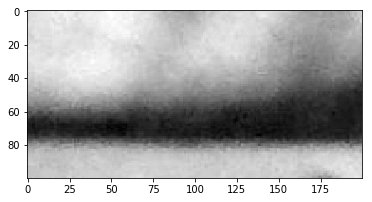

Tried 200 Times on http://moravianlives.bucknell.edu/MAF/Ful_SS_56Edwards-09.jpg
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_SS_56Edwards-09.jpg: 14
Creating trainset for Edwards, Ann Georgiana
Number of training patches from Edwards, Ann Georgiana: 300
Creating testset for Fletcher, Sarah Ann
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_SS_53Fletcher-10.jpg: 15
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_SS_53Fletcher-11.jpg: 15
Creating trainset for Fletcher, Sarah Ann
Number of training patches from Fletcher, Sarah Ann: 300
Creating testset for Larisch, Charles
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_05_LarischCharles-11.jpg: 15
Creating trainset for Larisch, Charles
Number of training patches from Larisch, Charles: 300
Creating testset for Molther, Philip Henry
Number of testpatches for http://moravianlives.bucknell.edu/MAF/Ful_3_04_MoltherPhilipHenry-08.jpg: 15
Number of testpatche

W0804 20:49:01.302321 140665072445312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 20:49:01.343076 140665072445312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 20:49:01.358455 140665072445312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 20:49:01.392432 140665072445312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0804 20:49:01.444006 140665072445312 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 102, 202, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 102, 202, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 51, 101, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 51, 101, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 25, 50, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 25, 50, 128)       73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 12, 25, 128)       0         
__________

In [0]:
#Trying get 300 patches from each writers

NUM_TRAIN_PATCHES_PER_WRITER = 300
(patch_row,patch_col) = (100,200)
TEST_PERCENT = .1
NUM_PATCHES = 15
MAX_RETRY = 200
NUM_EPOCHS = 100

url = "https://raw.githubusercontent.com/moravianlives/moravianlives/master/Bethlehem_UK-Image-lists/Fulneck_ImageFiles.md"
authors_url_dict = extract_url_links(url)
authors_list,train_patches_list,test_patches_list,train_tags_list,test_tags_list,test_img_ids = create_and_prep_patches(authors_url_dict)

NUM_AUTHORS = len(authors_list)

prediction_dataframe = fit_and_predict(train_patches_list, train_tags_list, test_patches_list, test_tags_list, authors_list, test_img_ids)
images_accuracy = plot_results(authors_list,prediction_dataframe)
#results_to_csv(prediction_dataframe,images_accuracy)